In [1]:
import pandas as pd
import numpy as np
import nltk
import pickle
import pyLDAvis.sklearn
from collections import Counter
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.options.mode.chained_assignment = None
pd.set_option('display.max_colwidth', 100)

In [14]:
data = pd.read_csv('rws_2.csv', converters={'lemmatized': eval})
data

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Unnamed: 0,asin,reviewText,summary,overall,reviewerID,category,no_contract,rating_description_str,tokenized,lower,no_punc,stopwords_removed,pos_tags,wordnet_pos,lemmatized
0,1000000,B000EX15NY,Edit: I returned these sandals and ordered directly from the Teva website (where the images stil...,Teva Has Massively Gone Downhill in Quality,1.0,A2BG97KDQT7KKK,Clothing_Shoes_and_Jewelry,"['Edit:', 'I', 'returned', 'these', 'sandals', 'and', 'ordered', 'directly', 'from', 'the', 'Tev...",Edit: I returned these sandals and ordered directly from the Teva website (where the images stil...,"['Edit', ':', 'I', 'returned', 'these', 'sandals', 'and', 'ordered', 'directly', 'from', 'the', ...","['edit', ':', 'i', 'returned', 'these', 'sandals', 'and', 'ordered', 'directly', 'from', 'the', ...","['edit', 'i', 'returned', 'these', 'sandals', 'and', 'ordered', 'directly', 'from', 'the', 'teva...","['edit', 'returned', 'sandals', 'ordered', 'directly', 'teva', 'website', 'images', 'still', 'sh...","[('edit', 'NN'), ('returned', 'VBD'), ('sandals', 'NNS'), ('ordered', 'VBN'), ('directly', 'RB')...","[('edit', 'n'), ('returned', 'v'), ('sandals', 'n'), ('ordered', 'v'), ('directly', 'r'), ('teva...","[edit, return, sandal, order, directly, teva, website, image, still, show, old, version, get, st..."
1,1000001,B000EX15NY,Haven't had them off my feet(other than at bedtime) since I received them! They are absolutely w...,They are absolutely wonderful!! Will probably wear them out,5.0,ASBUMDM2HYZ6D,Clothing_Shoes_and_Jewelry,"['have not', 'had', 'them', 'off', 'my', 'feet(other', 'than', 'at', 'bedtime)', 'since', 'I', '...",have not had them off my feet(other than at bedtime) since I received them! They are absolutely ...,"['have', 'not', 'had', 'them', 'off', 'my', 'feet', '(', 'other', 'than', 'at', 'bedtime', ')', ...","['have', 'not', 'had', 'them', 'off', 'my', 'feet', '(', 'other', 'than', 'at', 'bedtime', ')', ...","['have', 'not', 'had', 'them', 'off', 'my', 'feet', 'other', 'than', 'at', 'bedtime', 'since', '...","['feet', 'bedtime', 'since', 'received', 'absolutely', 'wonderful', 'probably', 'wear', 'thank-y...","[('feet', 'NNS'), ('bedtime', 'JJ'), ('since', 'IN'), ('received', 'VBN'), ('absolutely', 'RB'),...","[('feet', 'n'), ('bedtime', 'a'), ('since', 'n'), ('received', 'v'), ('absolutely', 'r'), ('wond...","[foot, bedtime, since, receive, absolutely, wonderful, probably, wear, thank-you]"
2,1000002,B000EX15NY,I love these! I bought a pair at the store but they are a little less expensive here. Most comf...,Great!,5.0,A28NRMAM1Y1PE6,Clothing_Shoes_and_Jewelry,"['I', 'love', 'these!', 'I', 'bought', 'a', 'pair', 'at', 'the', 'store', 'but', 'they', 'are', ...",I love these! I bought a pair at the store but they are a little less expensive here. Most comfo...,"['I', 'love', 'these', '!', 'I', 'bought', 'a', 'pair', 'at', 'the', 'store', 'but', 'they', 'ar...","['i', 'love', 'these', '!', 'i', 'bought', 'a', 'pair', 'at', 'the', 'store', 'but', 'they', 'ar...","['i', 'love', 'these', 'i', 'bought', 'a', 'pair', 'at', 'the', 'store', 'but', 'they', 'are', '...","['love', 'bought', 'pair', 'store', 'little', 'less', 'expensive', 'comfortable', 'flip', 'flop'...","[('love', 'VB'), ('bought', 'VBD'), ('pair', 'NN'), ('store', 'NN'), ('little', 'JJ'), ('less', ...","[('love', 'v'), ('bought', 'v'), ('pair', 'n'), ('store', 'n'), ('little', 'a'), ('less', 'r'), ...","[love, buy, pair, store, little, less, expensive, comfortable, flip, flop, ever]"
3,1000003,B000EX15NY,Always love teva!!!! Excellent price. Will order again!! Good color on the straps,Teva Flip Flop,5.0,AXIF1560XCJTV,Clothing_Shoes_and_Jewelry,"['Always', 'love', 'teva!!!!', 'Excellent', 'price.', 'Will', 'order', 'again!!', 'Good', 'color...",Always love teva!!!! Excellent price. Will order again!! Good color on the straps,"['Always', 'love', 'teva', '!', '!', '!', '!', 'Excellent', 'price', '.', 'Will', 'order', 'agai...","['always', 'love', 'teva', '!', '!', '!', '!', 'excellen

In [15]:
data = data[['asin', 'category','overall', 'lemmatized']]
data.head()

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,asin,category,overall,lemmatized
0,B000EX15NY,Clothing_Shoes_and_Jewelry,1.0,"[edit, return, sandal, order, directly, teva, website, image, still, show, old, version, get, st..."
1,B000EX15NY,Clothing_Shoes_and_Jewelry,5.0,"[foot, bedtime, since, receive, absolutely, wonderful, probably, wear, thank-you]"
2,B000EX15NY,Clothing_Shoes_and_Jewelry,5.0,"[love, buy, pair, store, little, less, expensive, comfortable, flip, flop, ever]"
3,B000EX15NY,Clothing_Shoes_and_Jewelry,5.0,"[always, love, teva, excellent, price, order, good, color, strap]"
4,B000EX15NY,Clothing_Shoes_and_Jewelry,4.0,"[shoe, wear, fairly, quickly, rough, terrain, walk, around, town/the, beach/, gardening, comfort..."


In [16]:
data['lemma_str'] = [' '.join(map(str,l)) for l in data['lemmatized']]
data.head()

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,asin,category,overall,lemmatized,lemma_str
0,B000EX15NY,Clothing_Shoes_and_Jewelry,1.0,"[edit, return, sandal, order, directly, teva, website, image, still, show, old, version, get, st...",edit return sandal order directly teva website image still show old version get style receive am...
1,B000EX15NY,Clothing_Shoes_and_Jewelry,5.0,"[foot, bedtime, since, receive, absolutely, wonderful, probably, wear, thank-you]",foot bedtime since receive absolutely wonderful probably wear thank-you
2,B000EX15NY,Clothing_Shoes_and_Jewelry,5.0,"[love, buy, pair, store, little, less, expensive, comfortable, flip, flop, ever]",love buy pair store little less expensive comfortable flip flop ever
3,B000EX15NY,Clothing_Shoes_and_Jewelry,5.0,"[always, love, teva, excellent, price, order, good, color, strap]",always love teva excellent price order good color strap
4,B000EX15NY,Clothing_Shoes_and_Jewelry,4.0,"[shoe, wear, fairly, quickly, rough, terrain, walk, around, town/the, beach/, gardening, comfort...",shoe wear fairly quickly rough terrain walk around town/the beach/ gardening comfortable hold we...


## Sentiment Analysis

In [17]:
data['sentiment'] = data['lemma_str'].apply(lambda x: TextBlob(x).sentiment.polarity)
data

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,asin,category,overall,lemmatized,lemma_str,sentiment
0,B000EX15NY,Clothing_Shoes_and_Jewelry,1.0,"[edit, return, sandal, order, directly, teva, website, image, still, show, old, version, get, st...",edit return sandal order directly teva website image still show old version get style receive am...,0.103301
1,B000EX15NY,Clothing_Shoes_and_Jewelry,5.0,"[foot, bedtime, since, receive, absolutely, wonderful, probably, wear, thank-you]",foot bedtime since receive absolutely wonderful probably wear thank-you,1.000000
2,B000EX15NY,Clothing_Shoes_and_Jewelry,5.0,"[love, buy, pair, store, little, less, expensive, comfortable, flip, flop, ever]",love buy pair store little less expensive comfortable flip flop ever,0.009167
3,B000EX15NY,Clothing_Shoes_and_Jewelry,5.0,"[always, love, teva, excellent, price, order, good, color, strap]",always love teva excellent price order good color strap,0.733333
4,B000EX15NY,Clothing_Shoes_and_Jewelry,4.0,"[shoe, wear, fairly, quickly, rough, terrain, walk, around, town/the, beach/, gardening, comfort...",shoe wear fairly quickly rough terrain walk around town/the beach/ gardening comfortable hold we...,-0.073333
...,...,...,...,...,...,...
999995,B00ND74WBA,Clothing_Shoes_and_Jewelry,4.0,"[nicely, make, sock, huge, give, friend, really, like]",nicely make sock huge give friend really like,0.400000
999996,B00ND74WBA,Clothing_Shoes_and_Jewelry,5.0,"[bit, big, liking, hey, get, job, do, need, winter, sock, keep, foot, warm, dry, snow/rain, etc,...",bit big liking hey get job do need winter sock keep foot warm dry snow/rain etc ... walk 1.5 mil...,0.186667
999997,B00ND74WBA,Clothing_Shoes_and_Jewelry,5.0,"[warm, comfortable]",warm comfortable,0.500000
999998,B00ND74WBA,Clothing_Shoes_and_Jewelry,5.0,"[comfortable, warm]",comfortable warm,0.500000


In [18]:
data.to_csv('rws_2_sentiment_data.csv')


/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Exploratory Data Analysis 

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


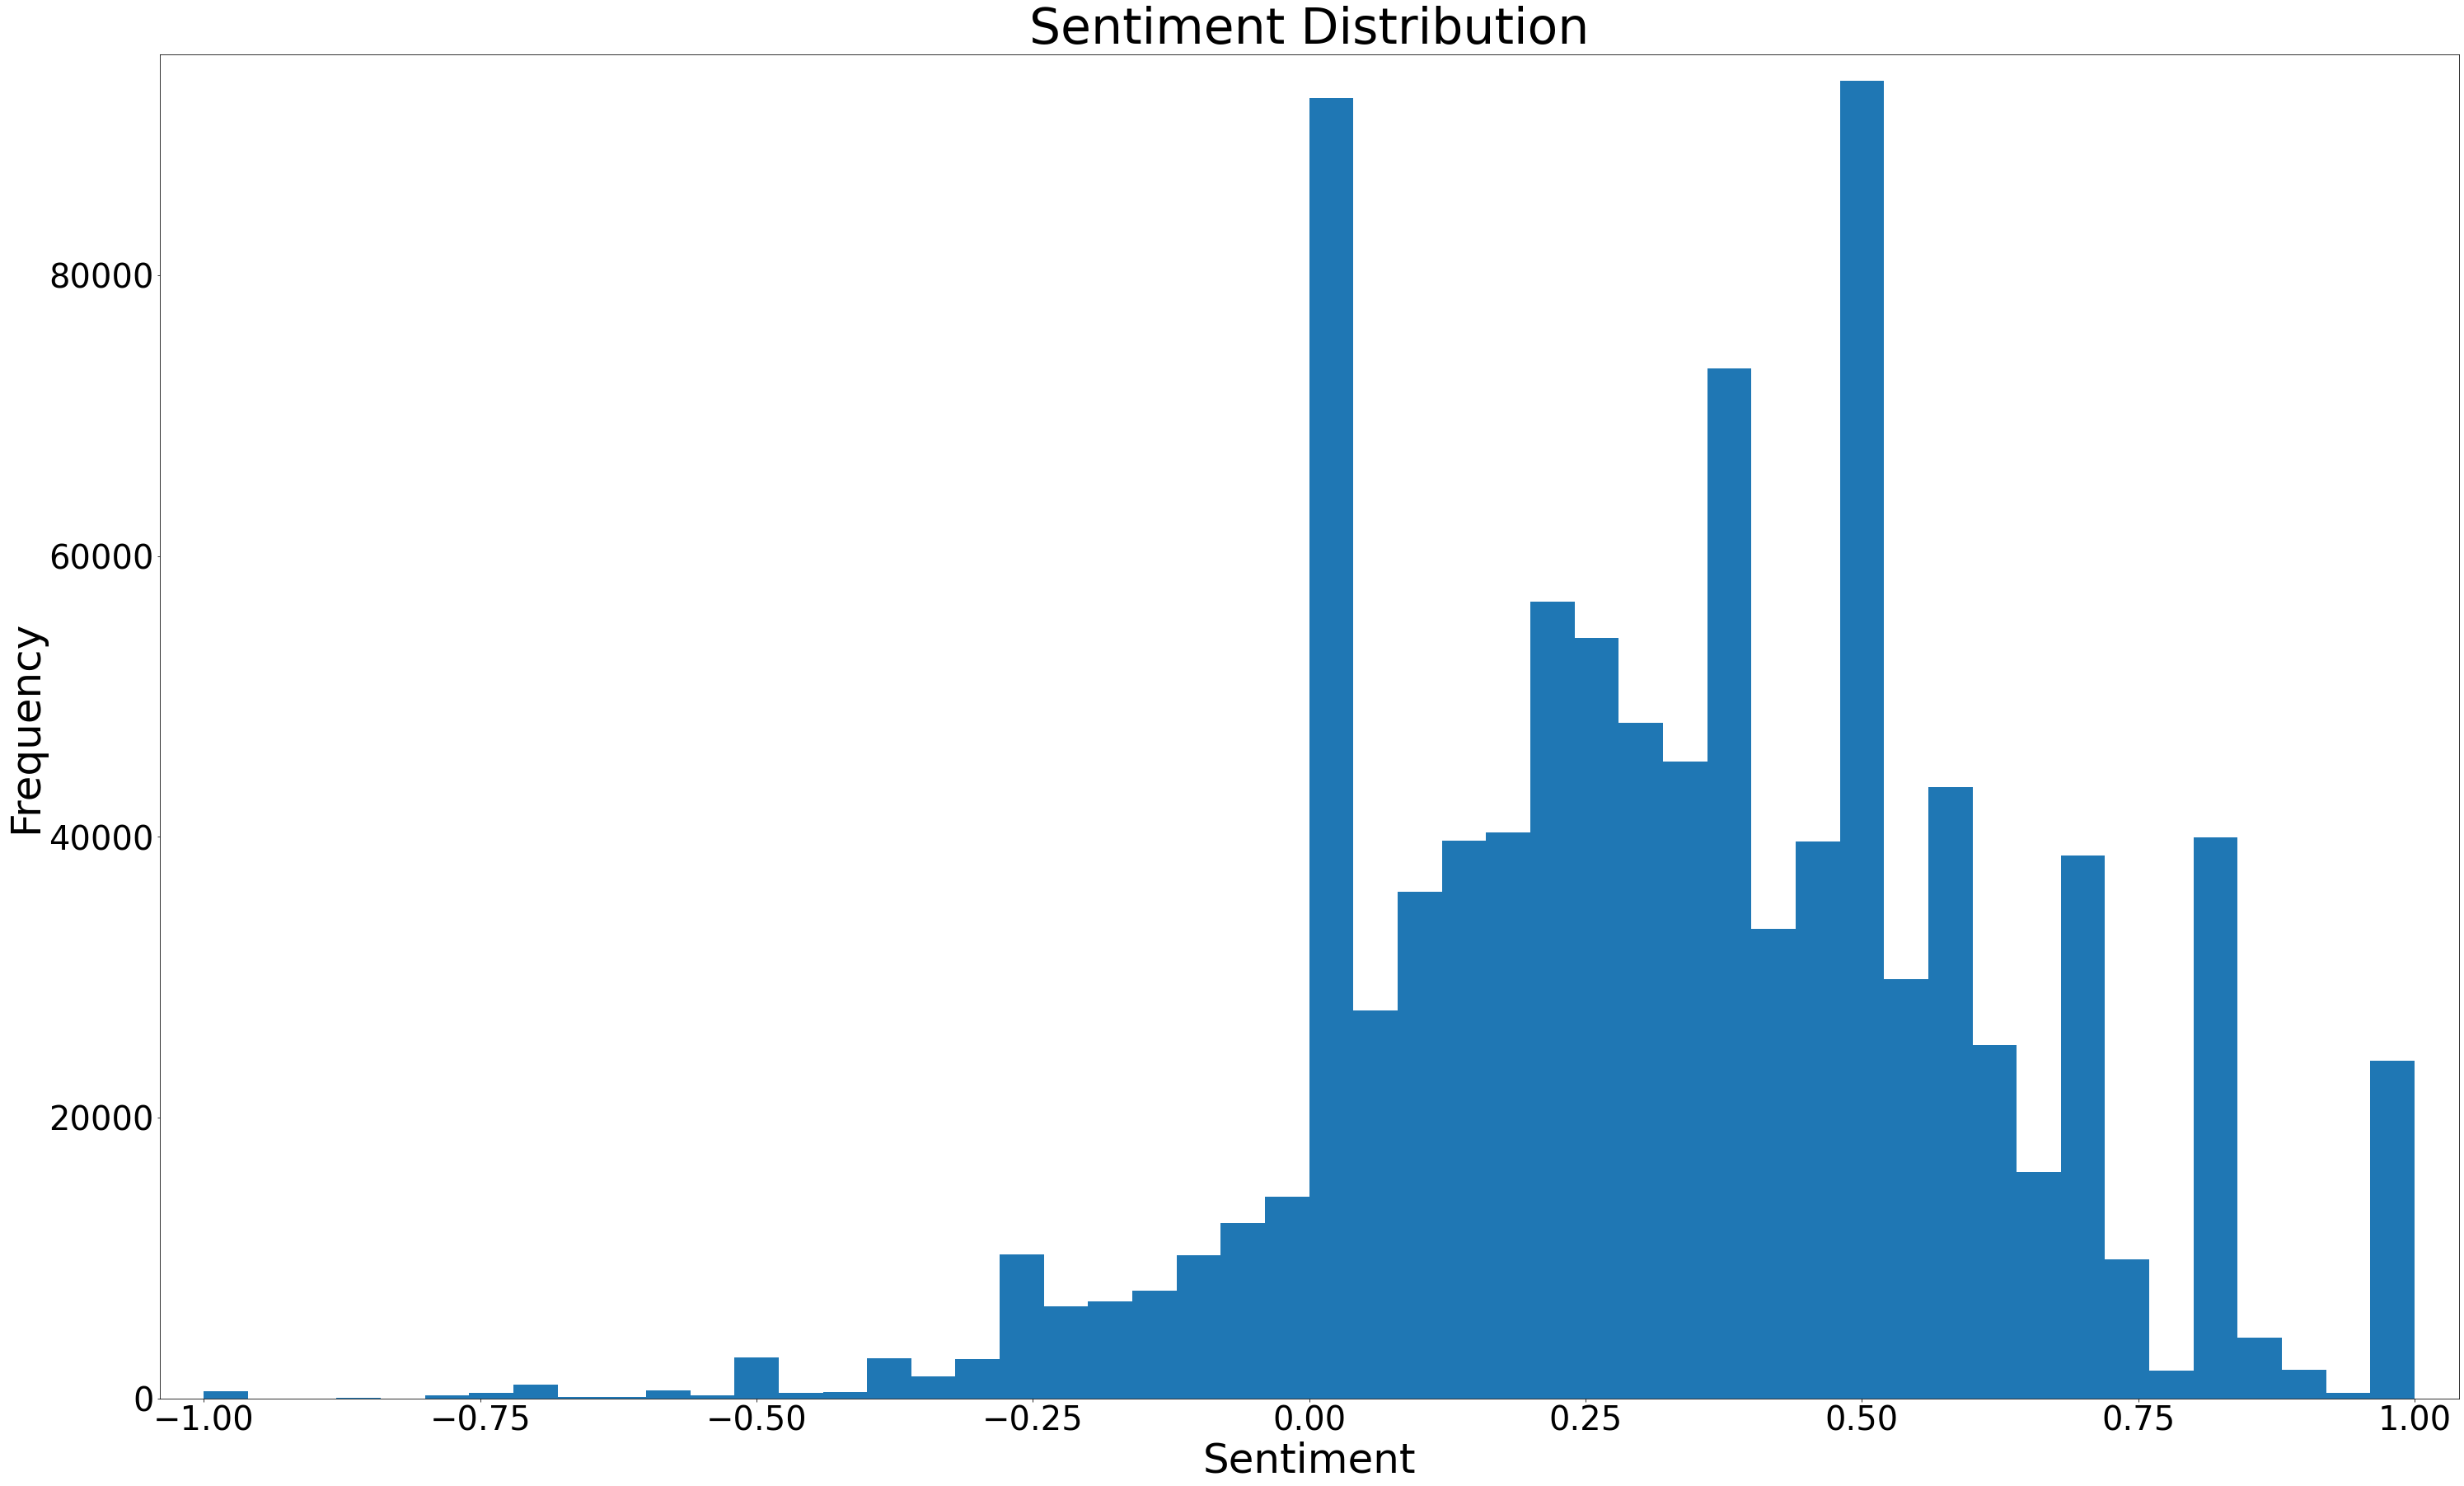

In [19]:
plt.figure(figsize=(50,30))
plt.margins(0.02)
plt.xlabel('Sentiment', fontsize=50)
plt.xticks(fontsize=40)
plt.ylabel('Frequency', fontsize=50)
plt.yticks(fontsize=40)
plt.hist(data['sentiment'], bins=50)
plt.title('Sentiment Distribution', fontsize=60)
plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:title={'center':'Percentage of Ratings'}, ylabel='overall'>

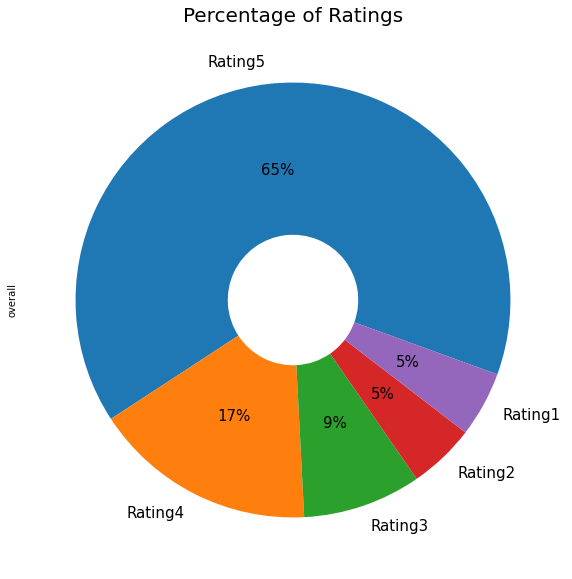

In [20]:
plt.figure(figsize=(30,10))
plt.title('Percentage of Ratings', fontsize=20)
data.overall.value_counts().plot(kind='pie', labels=['Rating5', 'Rating4', 'Rating3', 'Rating2', 'Rating1'],
                              wedgeprops=dict(width=.7), autopct='%1.0f%%', startangle= -20, 
                              textprops={'fontsize': 15})

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


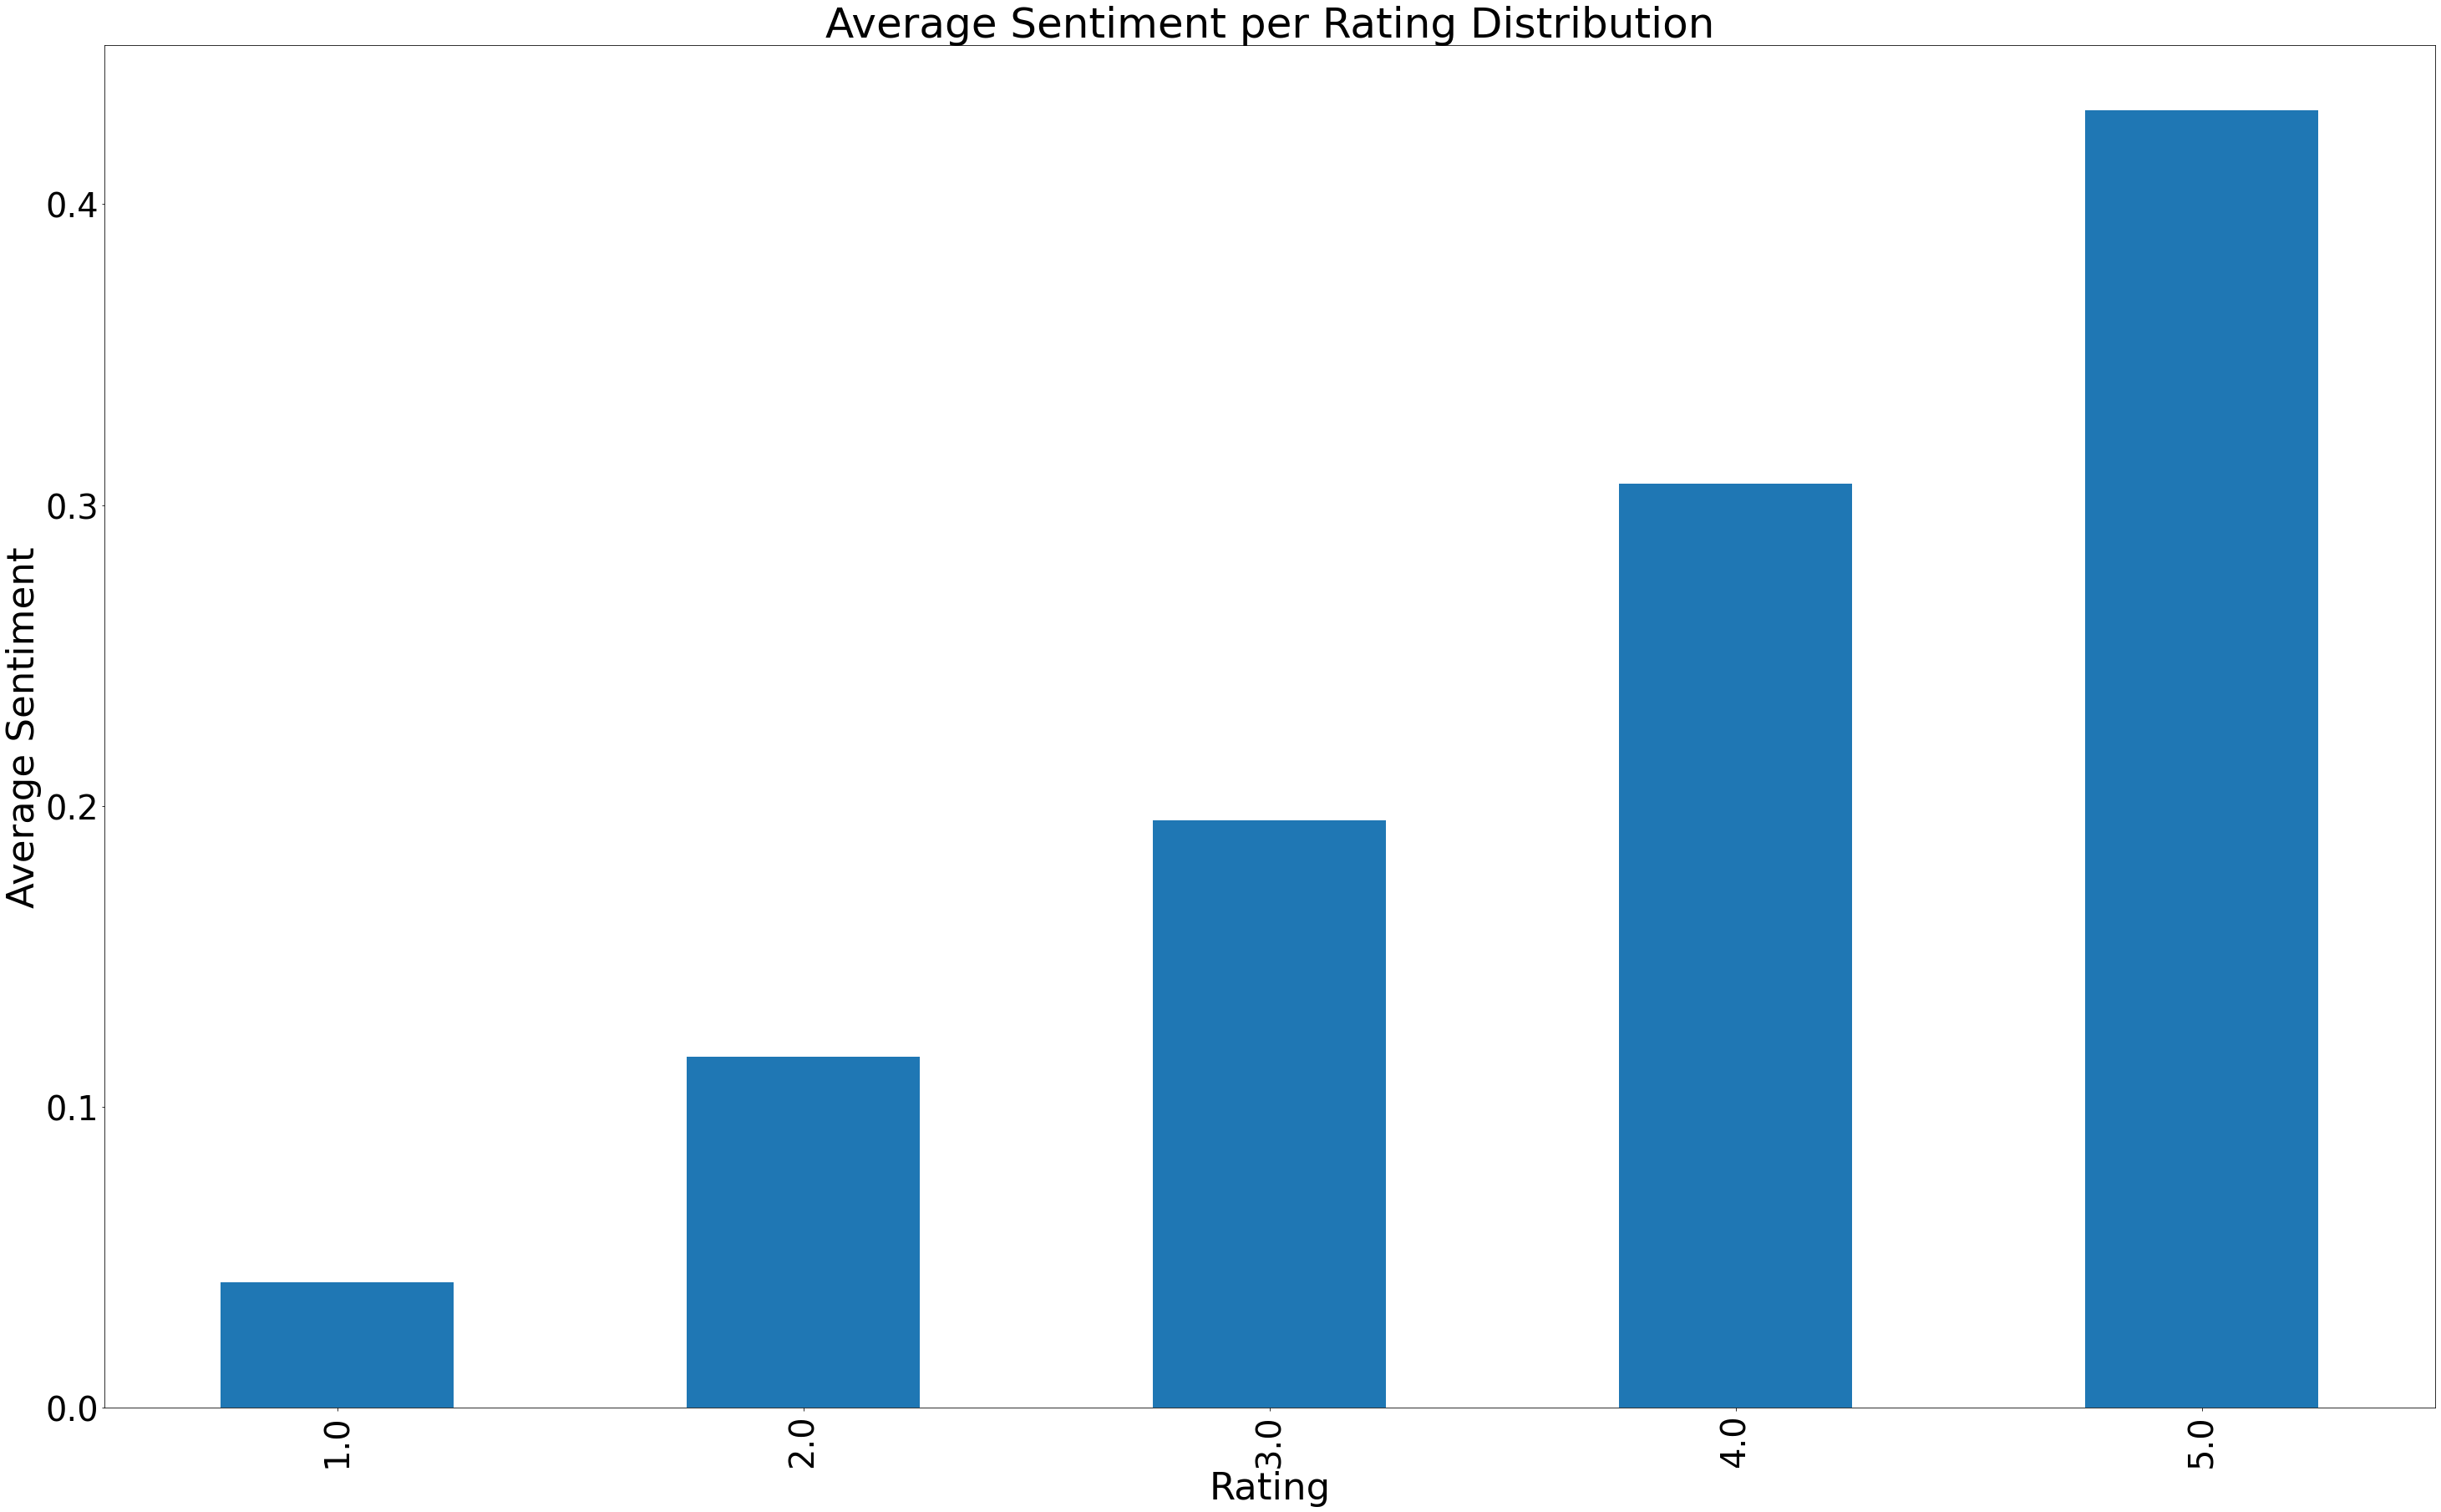

In [8]:
polarity_avg = data.groupby('overall')['sentiment'].mean().plot(kind='bar', figsize=(50,30))
plt.xlabel('Rating', fontsize=45)
plt.ylabel('Average Sentiment', fontsize=45)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.title('Average Sentiment per Rating Distribution', fontsize=50)
plt.show()

In [9]:
data['word_count'] = data['lemma_str'].apply(lambda x: len(str(x).split()))
data['review_len'] = data['lemma_str'].astype(str).apply(len)

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


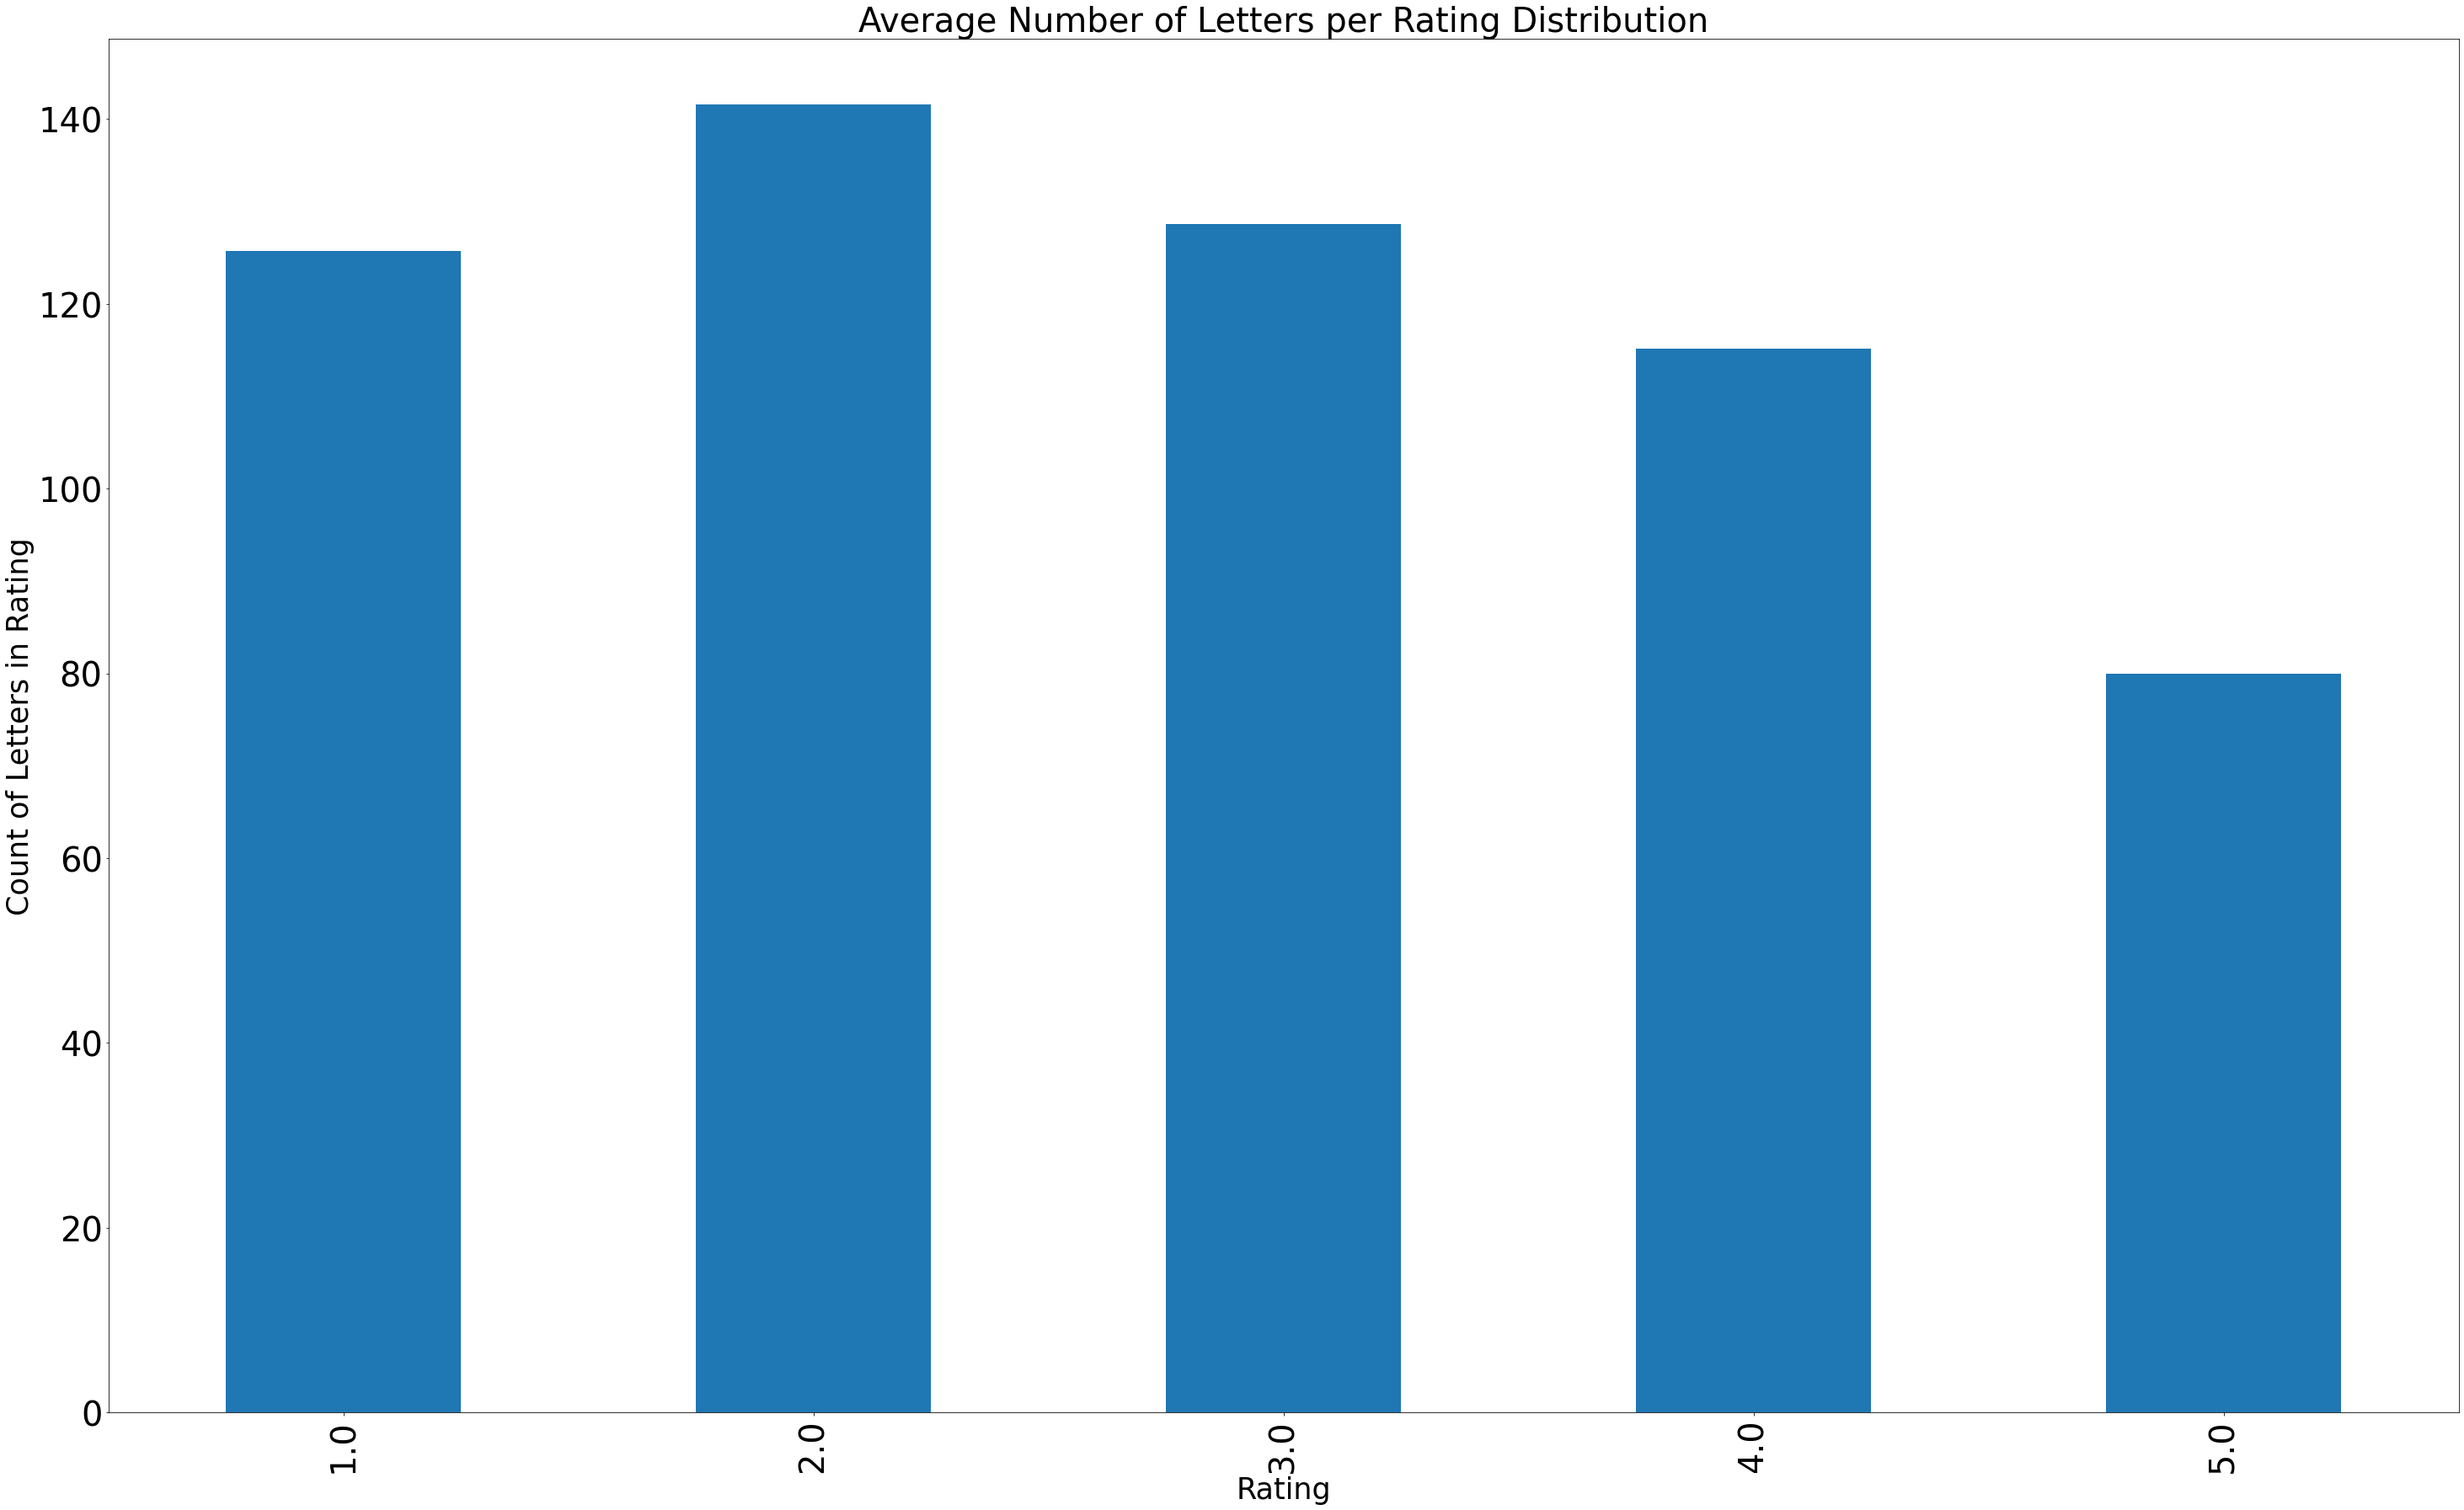

In [10]:
letter_avg = data.groupby('overall')['review_len'].mean().plot(kind='bar', figsize=(50,30))
plt.xlabel('Rating', fontsize=35)
plt.ylabel('Count of Letters in Rating', fontsize=35)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.title('Average Number of Letters per Rating Distribution', fontsize=40)
plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


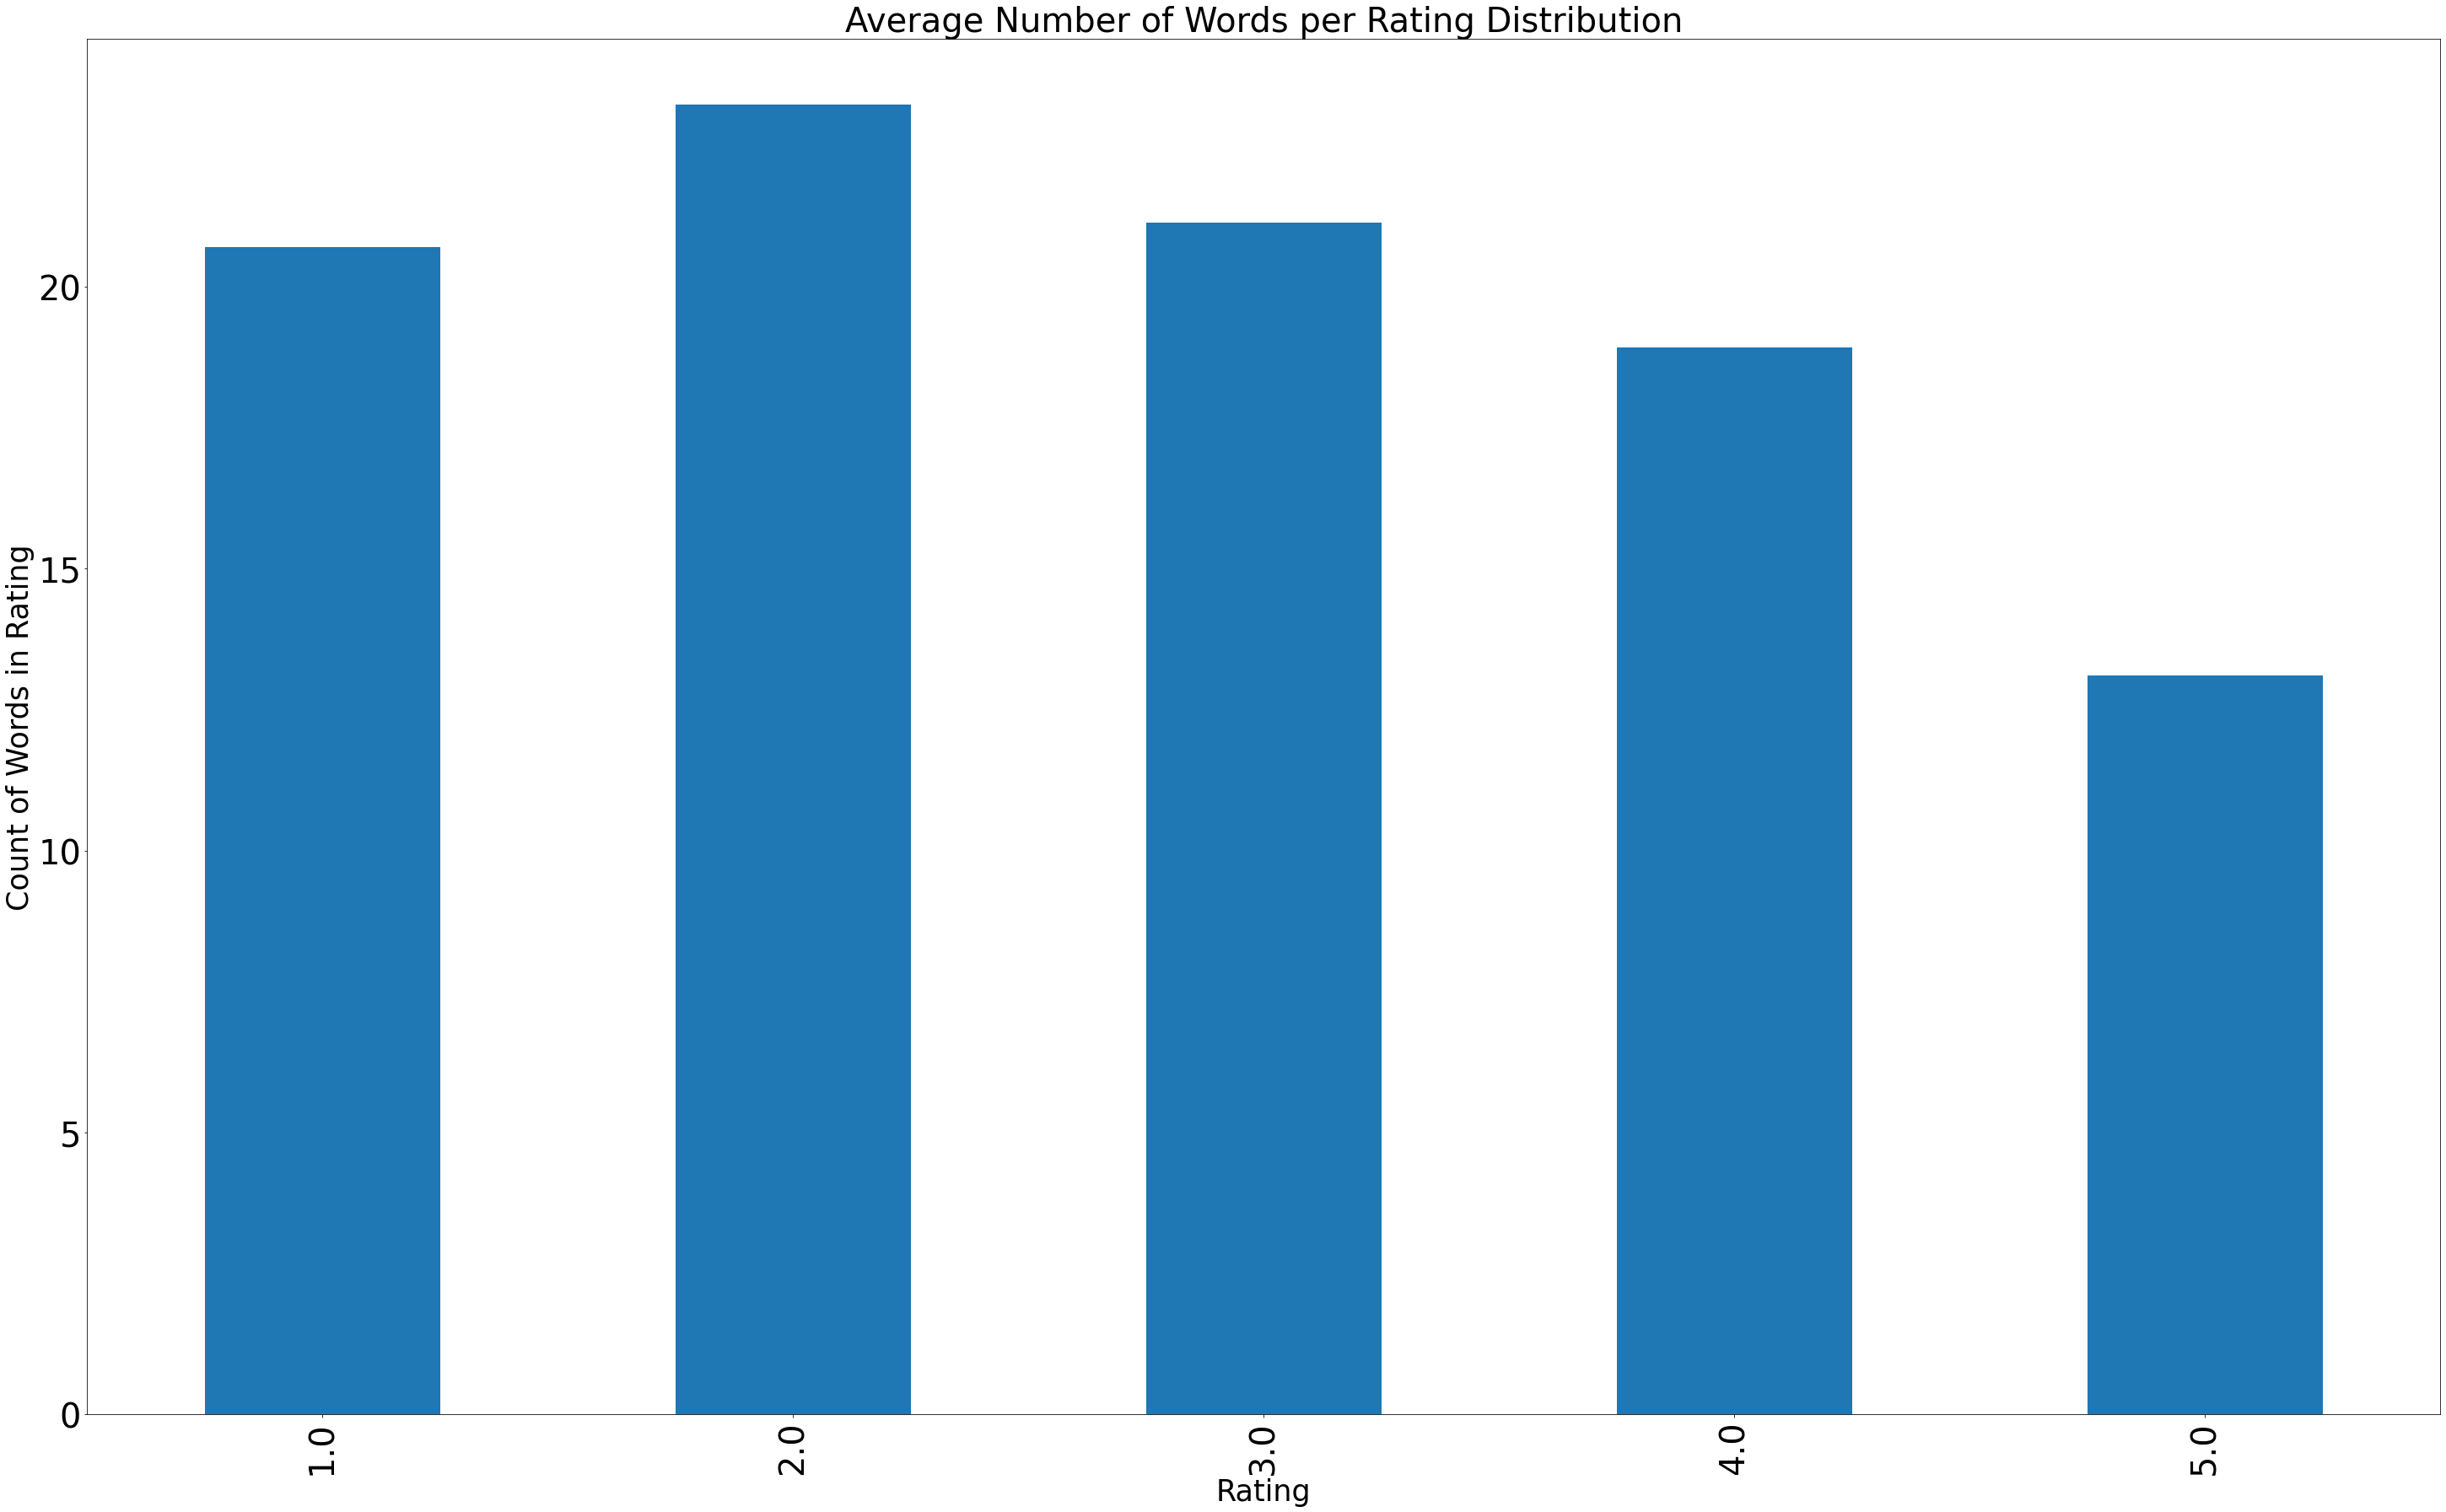

In [11]:
word_avg = data.groupby('overall')['word_count'].mean().plot(kind='bar', figsize=(50,30))
plt.xlabel('Rating', fontsize=35)
plt.ylabel('Count of Words in Rating', fontsize=35)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.title('Average Number of Words per Rating Distribution', fontsize=40)
plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:>

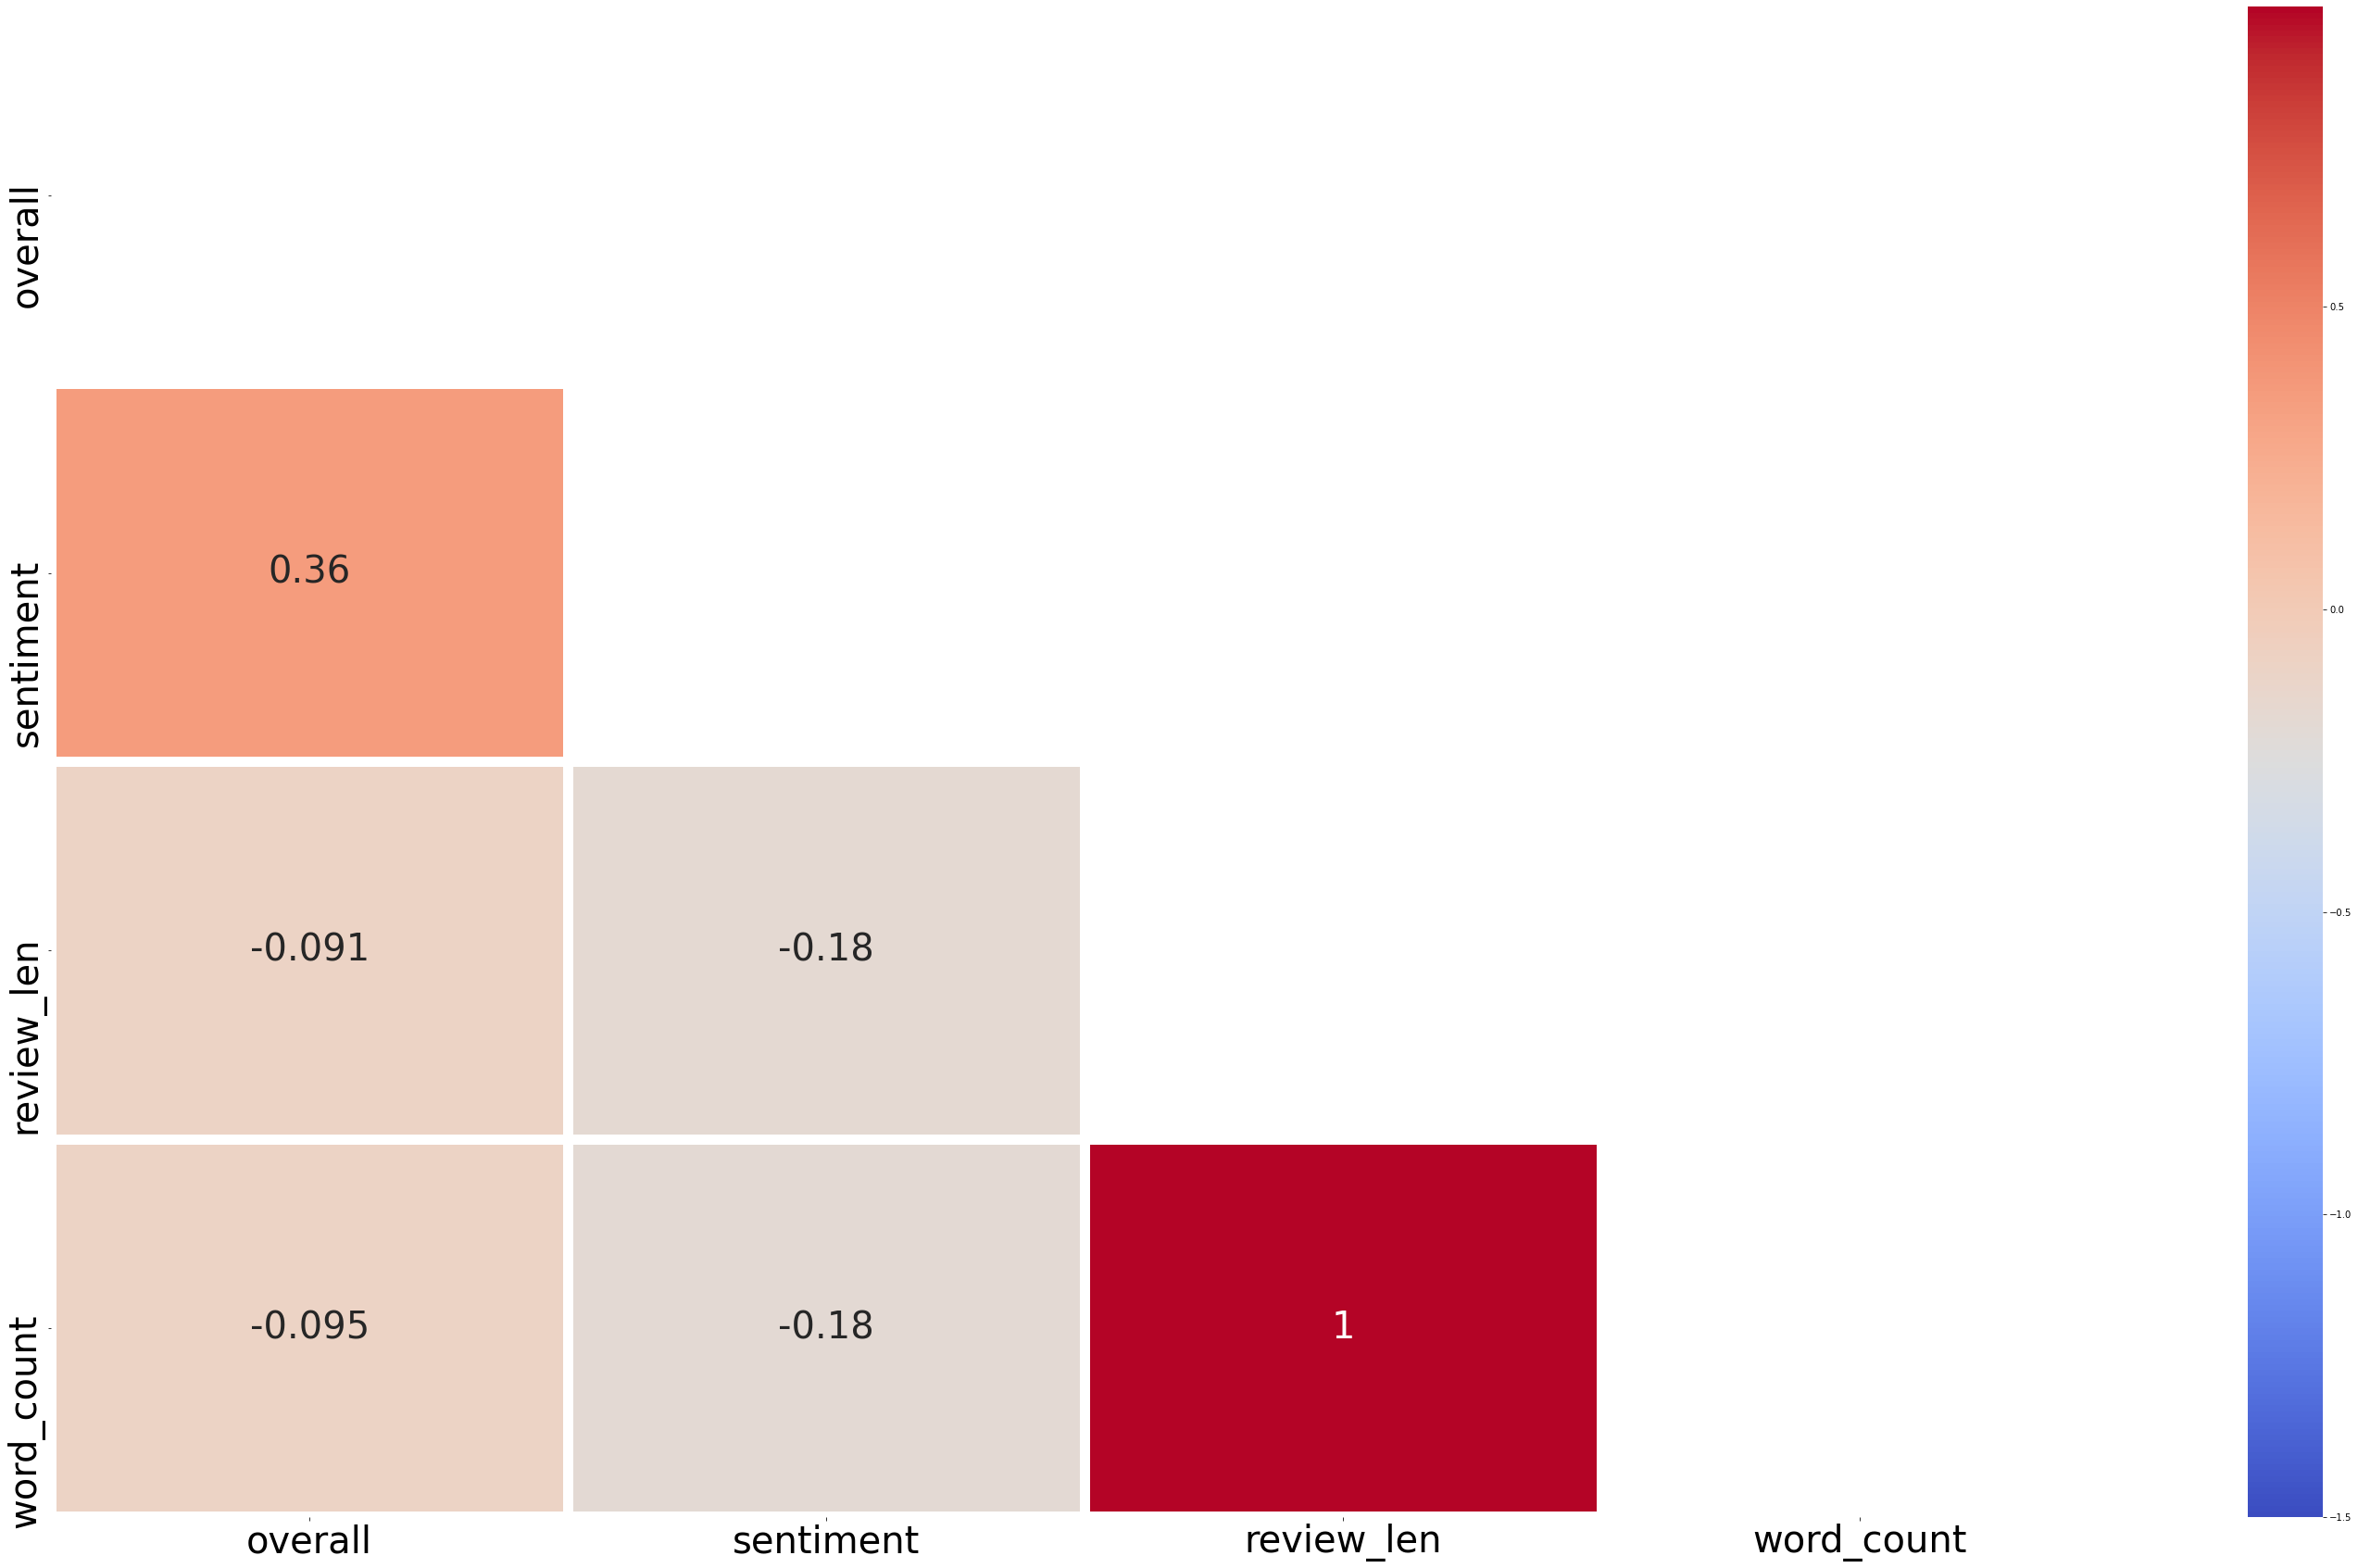

In [12]:
correlation = data[['overall','sentiment', 'review_len', 'word_count']].corr()
mask = np.zeros_like(correlation, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(50,30))
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
sns.heatmap(correlation, cmap='coolwarm', annot=True, annot_kws={"size": 40}, linewidths=10, vmin=-1.5, mask=mask)

In [13]:
words = data['lemma_str']
allwords = []
for wordlist in words:
    allwords.append(wordlist)

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


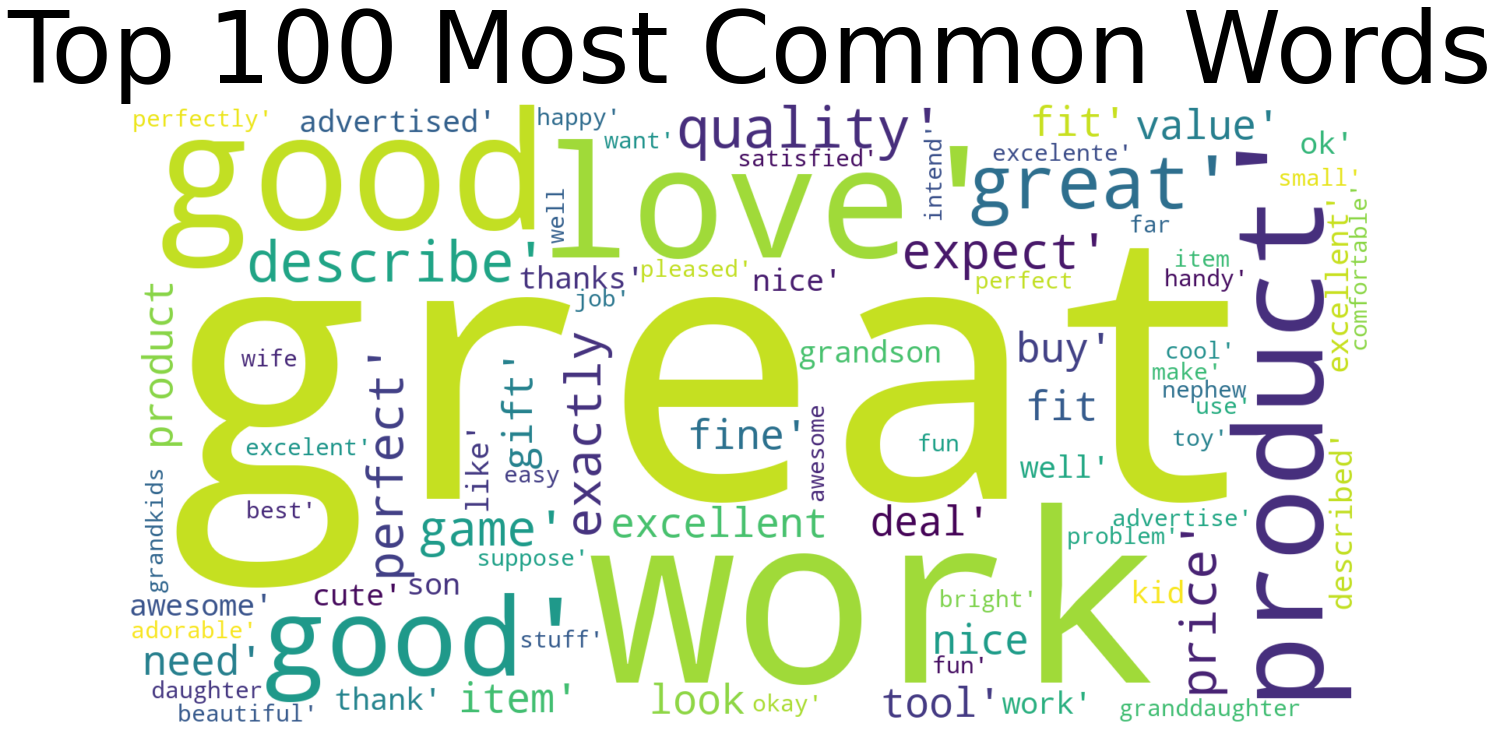

In [14]:
mostcommon = FreqDist(allwords).most_common(100)
wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(str(mostcommon))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common Words', fontsize=100)
plt.tight_layout(pad=0)
plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


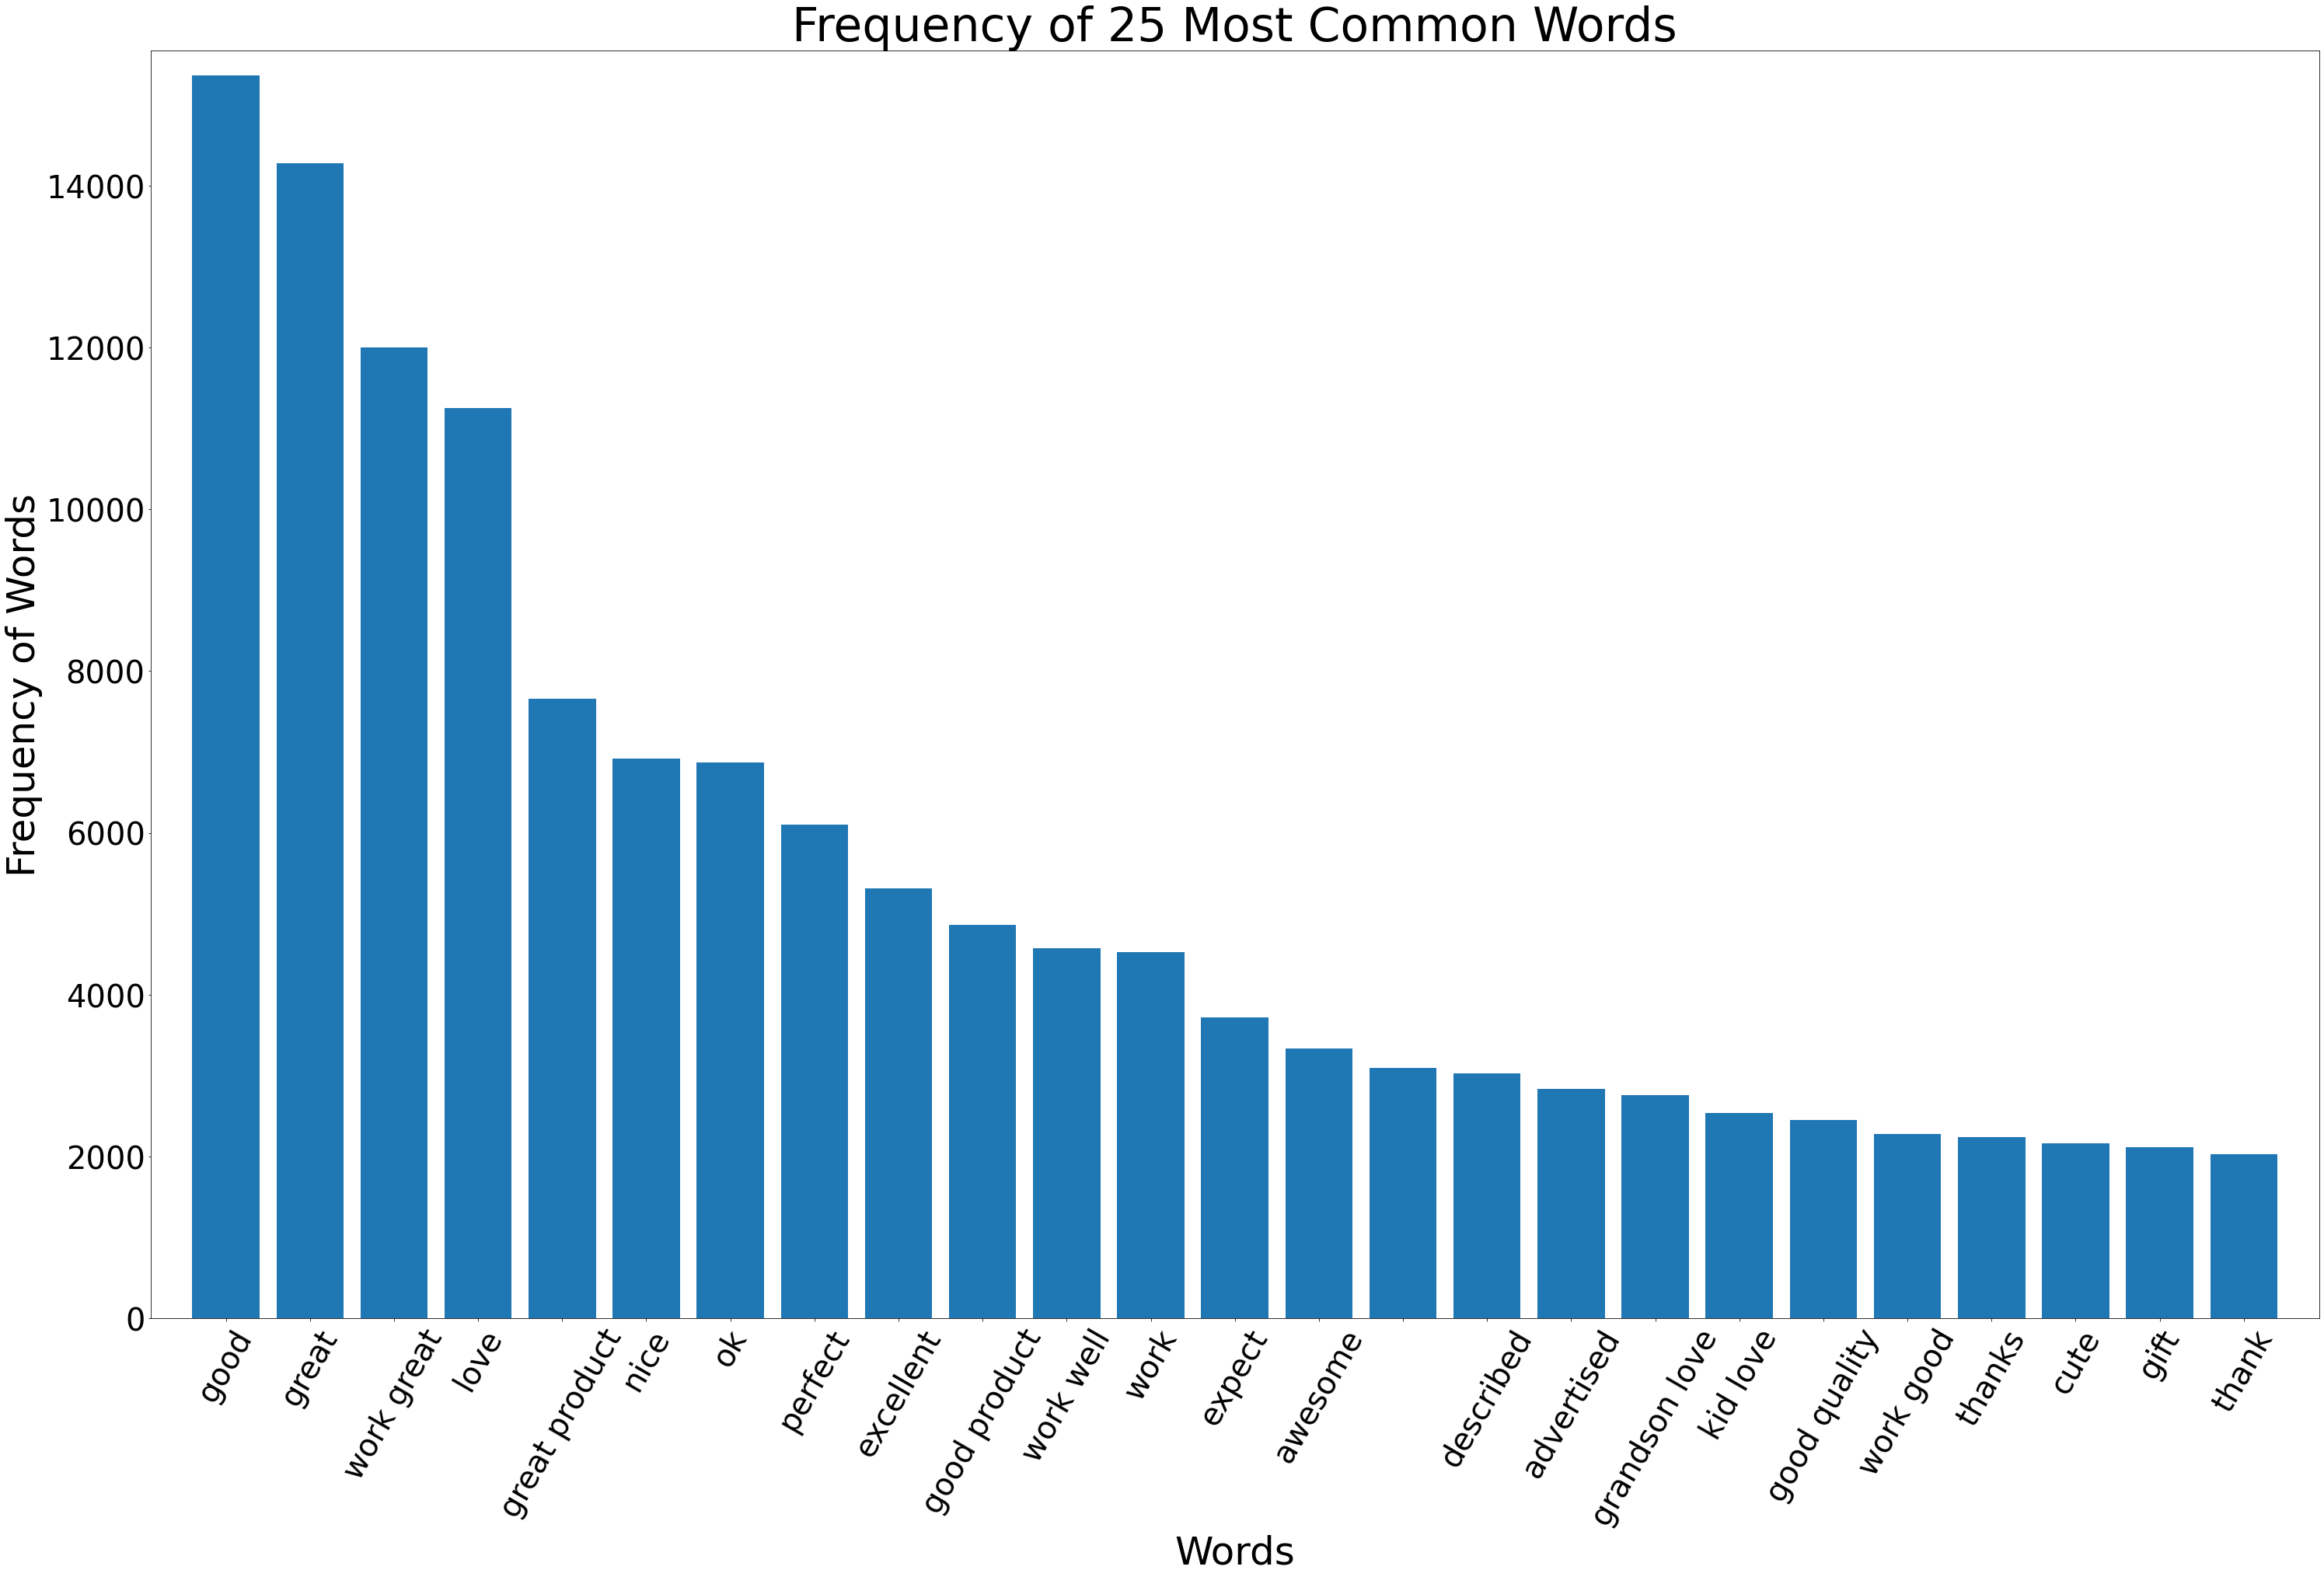

In [15]:
mostcommon_small = FreqDist(allwords).most_common(25)
x, y = zip(*mostcommon_small)
plt.figure(figsize=(50,30))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 Most Common Words', fontsize=60)
plt.show()

In [16]:
group_by = data.groupby('overall')['lemmatized'].apply(lambda x: Counter(' '.join(x).split()).most_common(25))
group_by_0 = group_by.iloc[0]
words0 = list(zip(*group_by_0))[0]
freq0 = list(zip(*group_by_0))[1]
plt.figure(figsize=(50,30))
plt.bar(words0, freq0)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 Most Common Words for Rating=1', fontsize=60)
plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


TypeError: sequence item 0: expected str instance, list found

In [ ]:
group_by_1 = group_by.iloc[1]
words1 = list(zip(*group_by_1))[0]
freq1 = list(zip(*group_by_1))[1]
plt.figure(figsize=(50,30))
plt.bar(words1, freq1)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 Most Common Words for Rating=2', fontsize=60)
plt.show()

In [ ]:
group_by_2 = group_by.iloc[2]
words2 = list(zip(*group_by_2))[0]
freq2 = list(zip(*group_by_2))[1]
plt.figure(figsize=(50,30))
plt.bar(words2, freq2)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 Most Common Words for Rating=3', fontsize=60)
plt.show()

In [ ]:
group_by_3 = group_by.iloc[3]
words3 = list(zip(*group_by_3))[0]
freq3 = list(zip(*group_by_3))[1]
plt.figure(figsize=(50,30))
plt.bar(words3, freq3)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 Most Common Words for Rating=4', fontsize=60)
plt.show()

In [ ]:
group_by_4 = group_by.iloc[4]
words4 = list(zip(*group_by_4))[0]
freq4 = list(zip(*group_by_4))[1]
plt.figure(figsize=(50,30))
plt.bar(words4, freq4)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 Most Common Words for Rating=5', fontsize=60)
plt.show()